In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Parameters

In [5]:
NB_EXPERIMENT_TYPES = ["performance", "interference"]

__Notebook config__

In [6]:
# Names to configure
NB_EXPERIMENT_TYPE = "performance"
NB_CONFIG = "thermal"

# Generated names
NB_EXPERIMENT = f"{NB_CONFIG}-cc_{NB_EXPERIMENT_TYPE}"
NB_CHANNEL = "f" + NB_CONFIG.split("+")[-1][0]

In [7]:
print("NB_EXPERIMENT_TYPE ", NB_EXPERIMENT_TYPE)
print("NB_CONFIG          ", NB_CONFIG)
print("NB_EXPERIMENT      ", NB_EXPERIMENT)

NB_EXPERIMENT_TYPE  performance
NB_CONFIG           thermal
NB_EXPERIMENT       thermal-cc_performance


In [8]:
assert NB_EXPERIMENT_TYPE in NB_EXPERIMENT_TYPES

In [9]:
config = TOML.load(f"configurations/{NB_EXPERIMENT}.toml")
print(TOML.dumps(config))

environments_to_execute = [
    "ARMv8",
    "Haswell"
]

phases = {
    "ARMv8": {
        "short": ["trainShortARMv8", "evalShortARMv8"],
        "normal": ["trainARMv8", "evalARMv8"],
    },
    "Haswell": {
        "short": ["trainShortHaswell", "evalShortHaswell"],
        "normal": ["trainHaswell", "evalHaswell"],
    },
}

name = "thermal-cc_performance"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "move"

[EXPERIMENT]
type = "PerformanceExperiment"
channel = "Thermal"

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_after_spawn = 30.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.PHASES.trainShortARMv8]
bit_count = 150
symbol_rates = "list(range(1, 11, 2))"
repetitions = 2

[EXPERIMENT.PHASES.evalShortARMv8]
bit_count = 500
symbol_rates = "list(range(1, 11, 2))"
repetitions = 2

[EXPERIMENT.PHASES.trainARMv8]
bit_count = 1500
symbol_rates = "list(arange(1, 20.1, 1))"
repetitions = 5

[EXPERIMENT.PHASES.evalARMv8]
bit_count = 5000
symbol_rates = "list(arange(1, 20.1, 1))"
repetitions = 5

[EXPERIMENT.PHASES.trainShortHaswell]
bit_count = 500
symbol_rates = "list(range(10, 201, 10))"
repetitions = 2

[EXPERIMENT.PHASES.evalShortHaswell]
bit_count = 1000
symbol_rates = "list(range(10, 201

## Analyse

1. Define which class of experiments to analyse (short of normal length)

In [10]:
SHORT = False

2. Check data collection status

In [11]:
for _experiment in [NB_EXPERIMENT]:
    for _platform, _phase_mapping in phases.items():
        for _class, _phases in _phase_mapping.items():
            for _phase in _phases:
                _log_folders = !ls -d data/$_experiment/$_phase*/$_platform 2>/dev/null | wc -l
                _logs = !ls -d data/$_experiment/$_phase*/$_platform/**.csv 2>/dev/null | wc -l
                print("experiment:", _experiment, "platform:", _platform, "phase:", _phase,
                      "folders:", _log_folders[0].strip(), "logs:", _logs[0].strip(), sep=" ")

experiment: thermal-cc_performance platform: ARMv8 phase: trainShortARMv8 folders: 0 logs: 0
experiment: thermal-cc_performance platform: ARMv8 phase: evalShortARMv8 folders: 0 logs: 0
experiment: thermal-cc_performance platform: ARMv8 phase: trainARMv8 folders: 20 logs: 200
experiment: thermal-cc_performance platform: ARMv8 phase: evalARMv8 folders: 20 logs: 200
experiment: thermal-cc_performance platform: Haswell phase: trainShortHaswell folders: 0 logs: 0
experiment: thermal-cc_performance platform: Haswell phase: evalShortHaswell folders: 0 logs: 0
experiment: thermal-cc_performance platform: Haswell phase: trainHaswell folders: 296 logs: 2960
experiment: thermal-cc_performance platform: Haswell phase: evalHaswell folders: 296 logs: 2960


3. Deserialisation

In [12]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, replace=False)

2019-09-10 10:46:48 :: unpicked an experiment instance <PerformanceExperiment at 0x7f05bc206e10 with Thermal channel, configured>
2019-09-10 10:46:48 :: git commit of unpickled experiment repo 'f0846ce4' does not match the commit in which the unpickling was performed '7bcc5997'


In [67]:
from importlib import reload

In [264]:
REP = 0
WITH_EVAL = True

an, tr, er = experiment.analyse_run_pair(
    "trainHaswell",
    "evalHaswell" if WITH_EVAL else None,
    idx=10,
    ingest_args=dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "env": "Haswell",
            "rep": REP,
            "matcher": exot.util.wrangle.Matcher("thermal", "msr", ["core"], [0]),
        }
    )
)
an

,bit_error,bit_rate,environment,matcher,phase,repetition,symbol_error,symbol_rate,trained_with,variable
0,0.0,15.0,Haswell,"<Matcher quantity='thermal', method='msr', val...",trainHaswell,0,0.0,15,,thermal_msr
1,0.0,15.0,Haswell,"<Matcher quantity='thermal', method='msr', val...",evalHaswell,0,0.0,15,trainHaswell,thermal_msr


In [265]:
tr.intermediates.io.src_log.head(), er.intermediates.io.src_log.head()

(   generator:timestamp::s  generator:desired::s  generator:offset::s
 0                0.000330        91159256738894                    0
 1                0.033726        91159290072227                62684
 2                0.067065        91159323405560                67739
 3                0.100420        91159356738893                89408
 4                0.133734        91159390072226                70344,
    generator:timestamp::s  generator:desired::s  generator:offset::s
 0                0.000193       194320509605225                    0
 1                0.033636       194320542938558               110041
 2                0.066978       194320576271891               118246
 3                0.100302       194320609605224               109500
 4                0.133651       194320642938557               124906)

In [267]:
trpl = PerformanceRunPlotter(tr, add_to_title="train") # reload(exot.plotting.run_plotter)
erpl = PerformanceRunPlotter(er, add_to_title="eval") if er else None

TypeError: PerformanceRunPlotter accepts only PerformanceRun instances

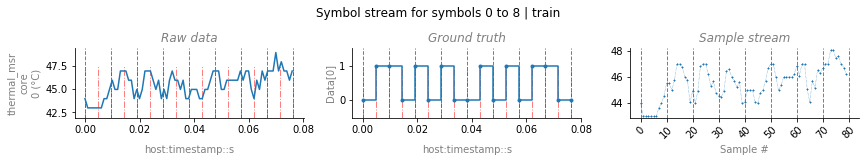

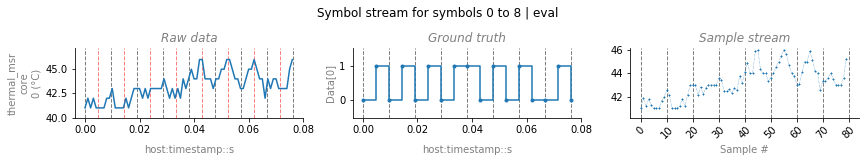

In [268]:
# trpl.plot_symbol_space()
# erpl.plot_symbol_space()

# trpl.plot_error()
# trpl.plot_rawstream()
trpl.plot_slicing(start=0, count=8)
# trpl.plot_slicing(start=800, count=8)
# trpl.plot_slicing(start=1400, count=8)

if erpl:
#     erpl.plot_error()
    erpl.plot_slicing(start=0, count=8)
#     erpl.plot_slicing(start=800, count=8)
#     erpl.plot_slicing(start=1400, count=8)

AttributeError: 'NoneType' object has no attribute 'get_text'

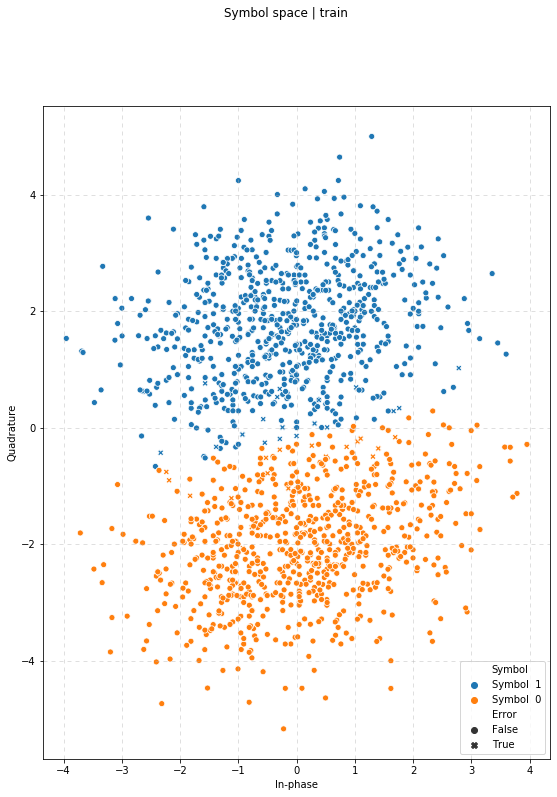

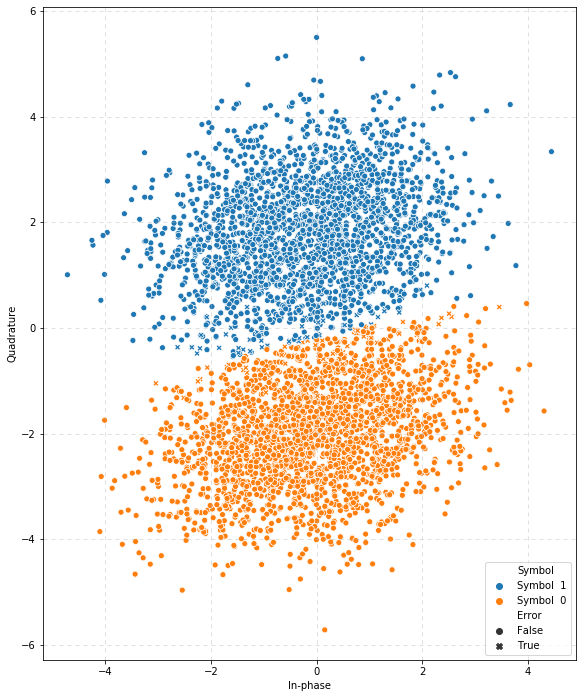

In [269]:
trpl.plot_symbol_space()
erpl.plot_symbol_space()

### 2019-09-09

{'phase': 'trainHaswell', 'bit_count': 1500, 'symbol_rate': 45, 'symbol_rate_id': 40, 'repetitions': 5}


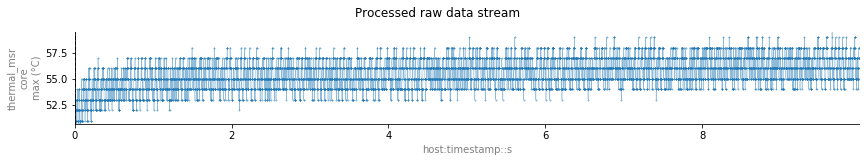

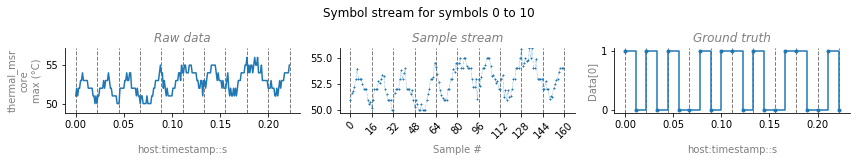

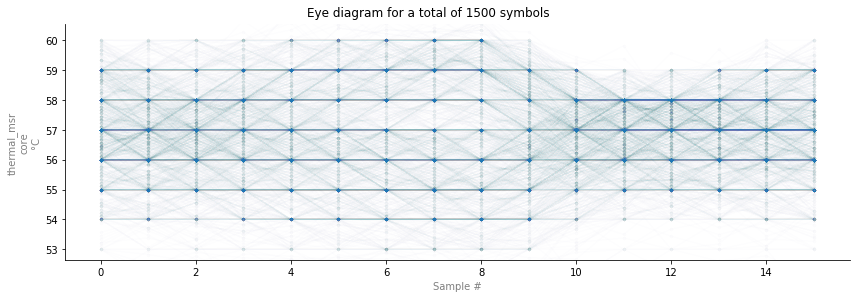

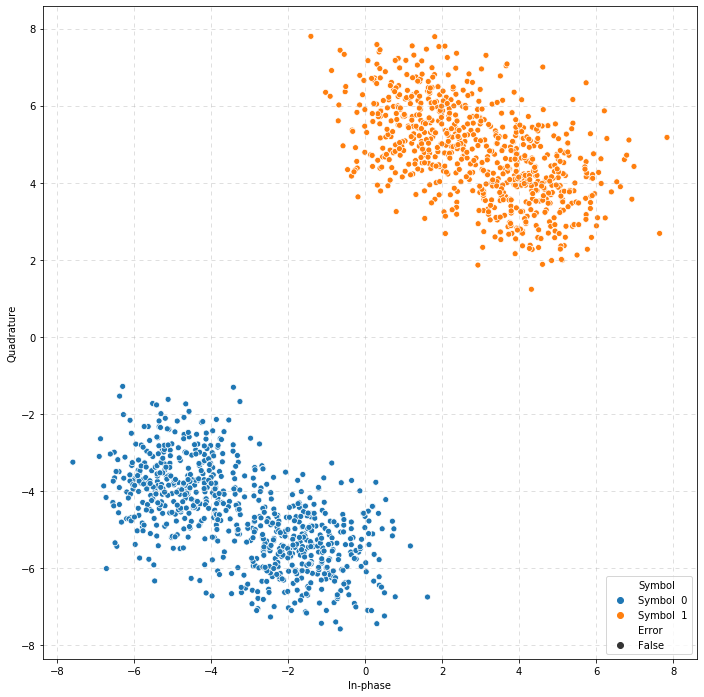

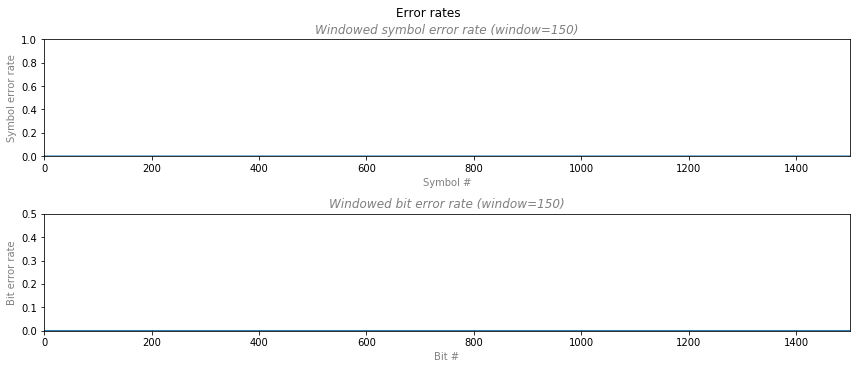

In [28]:
demo_run = experiment.phases["trainHaswell"][40]
print(demo_run.config)
demo_run.ingest(**ingest_args)

with PerformanceRunPlotter(demo_run) as plotter:
#     plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
#     plotter.plot_symstream()
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()

{'phase': 'evalHaswell', 'bit_count': 5000, 'symbol_rate': 45, 'symbol_rate_id': 40, 'repetitions': 5}


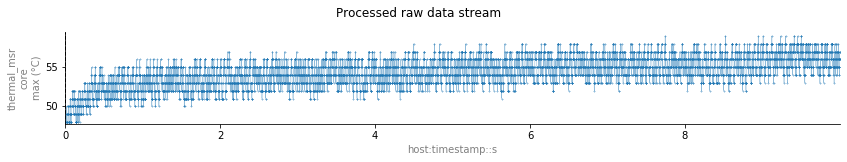

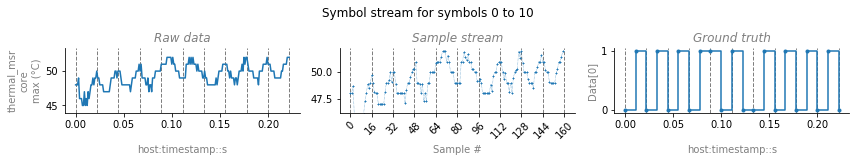

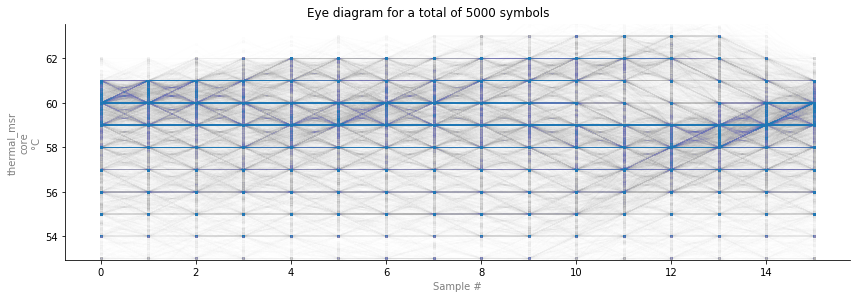

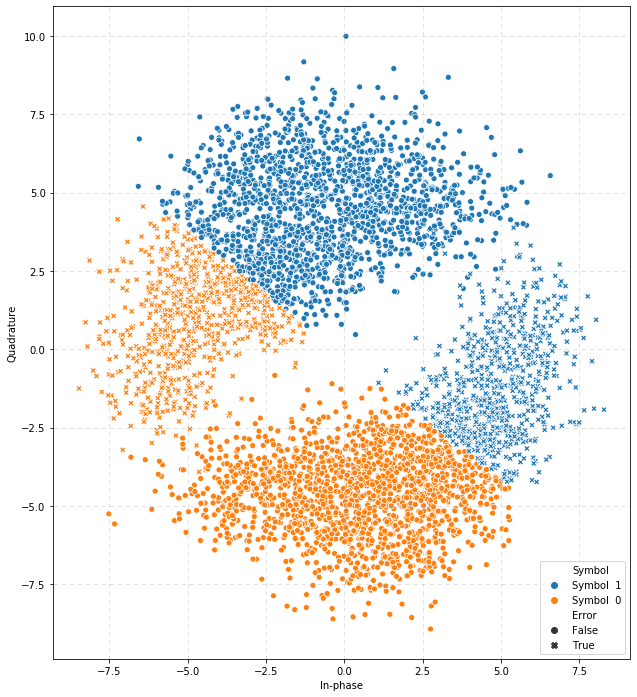

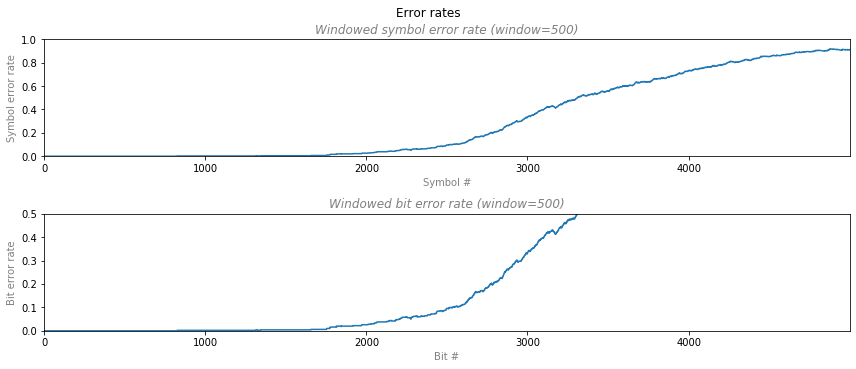

In [24]:
demo_run = experiment.phases["evalHaswell"][40]
print(demo_run.config)
demo_run.ingest(**ingest_args)

with PerformanceRunPlotter(demo_run) as plotter:
#     plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
#     plotter.plot_symstream()
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()

{'phase': 'evalHaswell', 'bit_count': 5000, 'symbol_rate': 75, 'symbol_rate_id': 70, 'repetitions': 5}


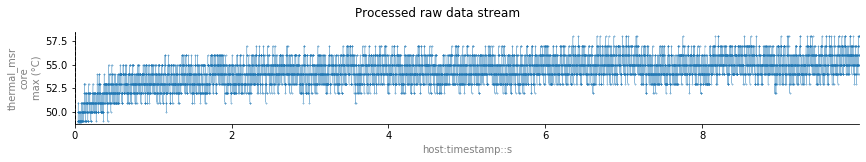

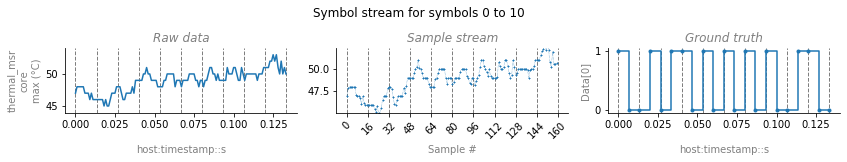

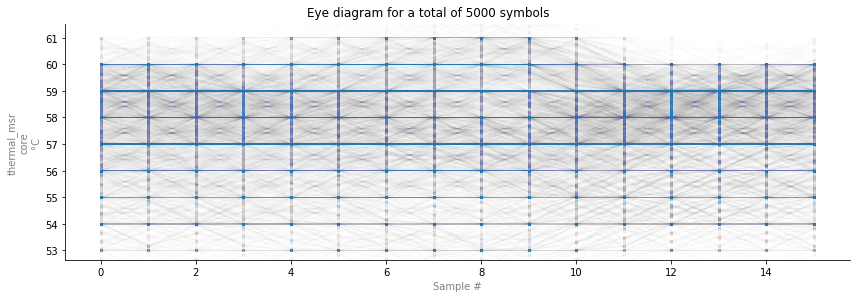

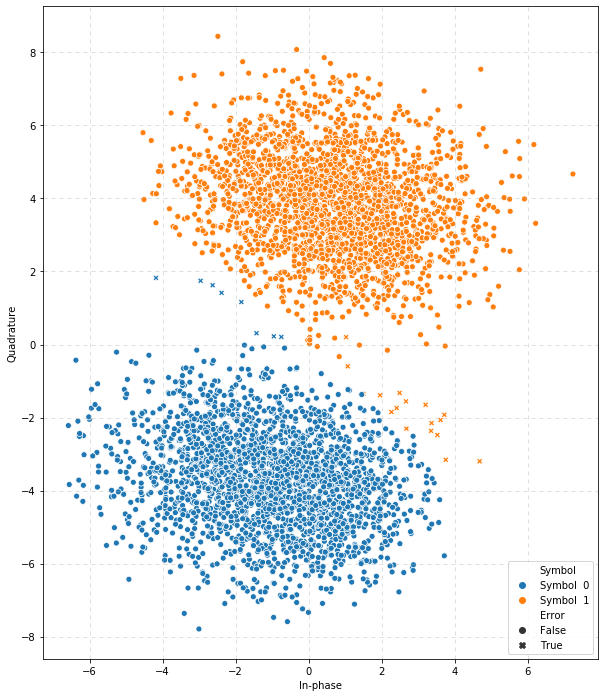

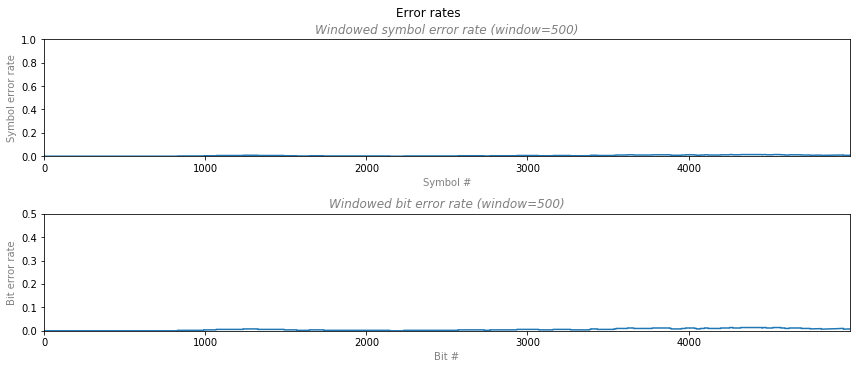

In [29]:
demo_run = experiment.phases["evalHaswell"][70]
print(demo_run.config)
demo_run.ingest(**ingest_args)

with PerformanceRunPlotter(demo_run) as plotter:
#     plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
#     plotter.plot_symstream()
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()

{'phase': 'trainHaswell', 'bit_count': 1500, 'symbol_rate': 75, 'symbol_rate_id': 70, 'repetitions': 5}


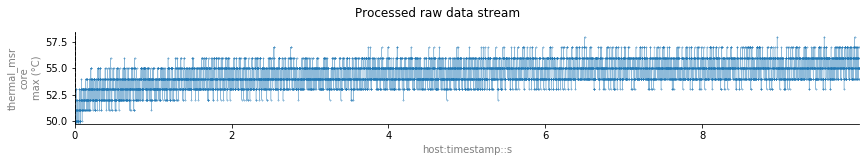

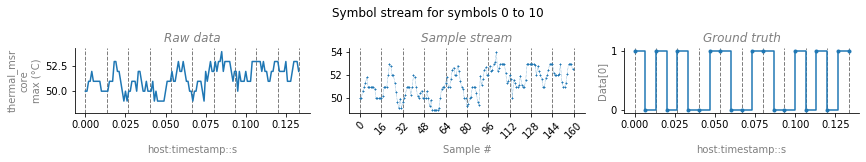

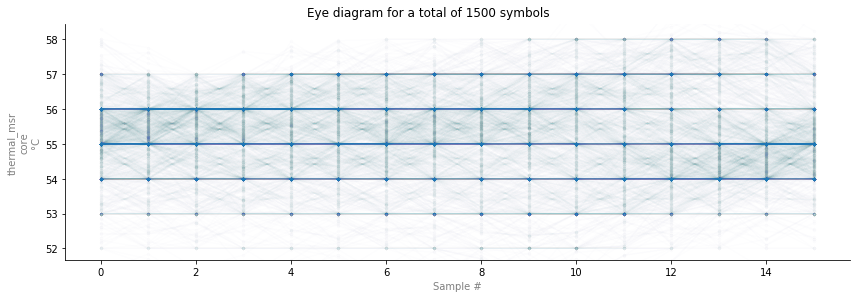

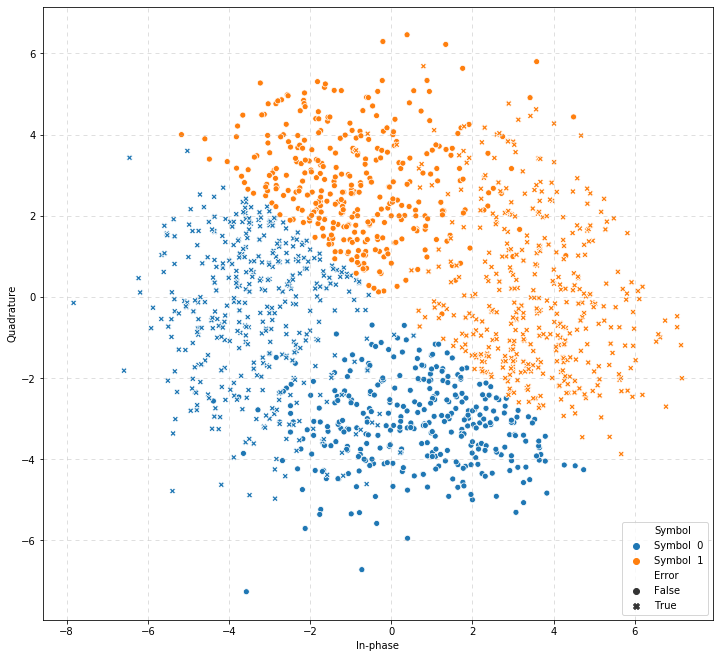

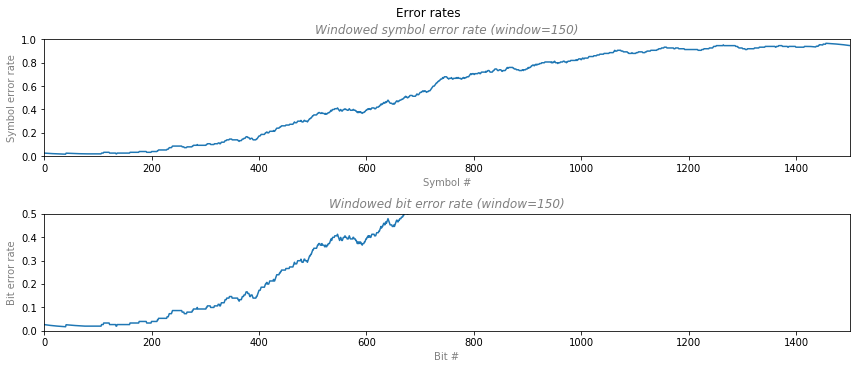

In [30]:
demo_run = experiment.phases["trainHaswell"][70]
print(demo_run.config)
demo_run.ingest(**ingest_args)

with PerformanceRunPlotter(demo_run) as plotter:
#     plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
#     plotter.plot_symstream()
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()

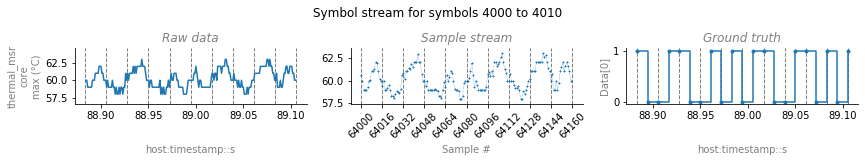

In [27]:
plotter.plot_slicing(start=4000)

5. Analyse the experiment

_Define the analysis arguments and phase mappings_

In [35]:
to_evaluate = "short" if SHORT else "normal"

analysis_args = {
    "ARMv8": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={"matcher": exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [0])},
    ),
    "Haswell": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": exot.util.wrangle.Matcher("thermal", "msr", ["core"], [0, 2, 4, 6]),
            "combine": "max",
        },
    ),
}

phase_mappings = {
    "ARMv8": {
        "short": ["trainShortARMv8", "evalShortARMv8"],
        "normal": ["trainARMv8", "evalARMv8"],
    },
    "Haswell": {
        "short": ["trainShortHaswell", "evalShortHaswell"],
        "normal": ["trainHaswell", "evalHaswell"],
    },
}

6. Calculate the performance metrics

In [36]:
for env in ["Haswell"]: # phase_mappings:
    experiment.calculate_performance_metrics(
        phase_mapping=dict([tuple(phase_mappings[env][to_evaluate])]),
        envs=[env],
        reps=[],
        **analysis_args[env],
    )

2019-09-09 15:05:32 :: analysing performance for phases: trainHaswell -> evalHaswell
2019-09-09 15:05:32 :: \_ analysing performance for env: Haswell
2019-09-09 15:05:47 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:00 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:12 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:24 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:36 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:48 :: \_ analysing performance for env: Haswell
2019-09-09 15:06:59 :: \_ analysing performance for env: Haswell
2019-09-09 15:07:10 :: \_ analysing performance for env: Haswell
2019-09-09 15:07:20 :: \_ analysing performance for env: Haswell
2019-09-09 15:07:30 :: \_ analysing performance for env: Haswell
2019-09-09 15:07:41 :: \_ analysing performance for env: Haswell
2019-09-09 15:07:50 :: \_ analysing performance for env: Haswell
2019-09-09 15:08:00 :: \_ analysing performance for env: Haswell
2019-

2019-09-09 15:21:56 :: \_ analysing performance for env: Haswell
2019-09-09 15:22:06 :: \_ analysing performance for env: Haswell
2019-09-09 15:22:22 :: \_ analysing performance for env: Haswell
2019-09-09 15:22:32 :: \_ analysing performance for env: Haswell
2019-09-09 15:22:42 :: \_ analysing performance for env: Haswell
2019-09-09 15:22:51 :: \_ analysing performance for env: Haswell
2019-09-09 15:23:02 :: \_ analysing performance for env: Haswell
2019-09-09 15:23:21 :: \_ analysing performance for env: Haswell
2019-09-09 15:23:37 :: \_ analysing performance for env: Haswell
2019-09-09 15:23:46 :: \_ analysing performance for env: Haswell
2019-09-09 15:23:58 :: \_ analysing performance for env: Haswell
2019-09-09 15:24:17 :: \_ analysing performance for env: Haswell
2019-09-09 15:24:34 :: \_ analysing performance for env: Haswell
2019-09-09 15:24:46 :: \_ analysing performance for env: Haswell
2019-09-09 15:25:05 :: \_ analysing performance for env: Haswell
2019-09-09 15:25:20 :: \_

2019-09-09 15:40:53 :: \_ analysing performance for env: Haswell
2019-09-09 15:41:08 :: \_ analysing performance for env: Haswell
2019-09-09 15:41:21 :: \_ analysing performance for env: Haswell
2019-09-09 15:41:30 :: \_ analysing performance for env: Haswell
2019-09-09 15:41:47 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:07 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:21 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:28 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:37 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:45 :: \_ analysing performance for env: Haswell
2019-09-09 15:42:58 :: \_ analysing performance for env: Haswell
2019-09-09 15:43:11 :: \_ analysing performance for env: Haswell
2019-09-09 15:43:21 :: \_ analysing performance for env: Haswell
2019-09-09 15:43:31 :: \_ analysing performance for env: Haswell
2019-09-09 15:43:45 :: \_ analysing performance for env: Haswell
2019-09-09 15:43:59 :: \_

_Show the performance metrics..._

In [31]:
del experiment.performance_metrics

In [12]:
experiment.performance_metrics.head()

,phase,trained_with,environment,bit_rate,symbol_rate,repetition,bit_error,symbol_error,matcher,variable
0,trainARMv8,,ARMv8,1.0,1.0,0,0.0,0.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs
1,evalARMv8,trainARMv8,ARMv8,1.0,1.0,0,0.0,0.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs
2,trainARMv8,,ARMv8,1.0,1.0,1,0.0,0.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs
3,evalARMv8,trainARMv8,ARMv8,1.0,1.0,1,0.0,0.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs
4,trainARMv8,,ARMv8,1.0,1.0,2,0.0,0.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs


_...and the aggregated performance metrics (mean of repetitions)_

In [13]:
experiment.aggregate_performance_metrics()

,phase,trained_with,environment,bit_rate,symbol_rate,matcher,variable,bit_error,symbol_error
0,evalARMv8,trainARMv8,ARMv8,1.0,1.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.000000,0.000000
1,evalARMv8,trainARMv8,ARMv8,2.0,2.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.000000,0.000000
2,evalARMv8,trainARMv8,ARMv8,3.0,3.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.000000,0.000000
3,evalARMv8,trainARMv8,ARMv8,4.0,4.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.000080,0.000080
4,evalARMv8,trainARMv8,ARMv8,5.0,5.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.016120,0.016120
5,evalARMv8,trainARMv8,ARMv8,6.0,6.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.359480,0.359480
6,evalARMv8,trainARMv8,ARMv8,7.0,7.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.246480,0.246480
7,evalARMv8,trainARMv8,ARMv8,8.0,8.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.396080,0.396080
8,evalARMv8,trainARMv8,ARMv8,9.0,9.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.416040,0.416040
9,evalARMv8,trainARMv8,ARMv8,10.0,10.0,"<Matcher quantity='thermal', method='sysfs', v...",thermal_sysfs,0.469560,0.469560


7. Serialise the experiment with the calculated performance metrics

In [ ]:
experiment.write()

8. Get aggregated performance metrics for each environment and phase and output as CSV

In [ ]:
for env in phase_mappings:
    eval_phase = phase_mappings[env][to_evaluate][-1]
    BERs = wrangle.filter_data(
        experiment.aggregate_performance_metrics(), environment=env, phase=eval_phase
    )

    PREFIX = "TH" + ("_INT_" if NB_EXPERIMENT_TYPE == "interference" else "")

    pd.DataFrame({"bit_rate": BERs["bit_rate"], "bit_error": BERs["bit_error"]}).to_csv(
        "./data/BER_{}_{}_{}.dat".format(PREFIX, eval_phase, env),
        sep=",",
        encoding="utf-8",
        index=False,
    )

9. Plot performance metrics

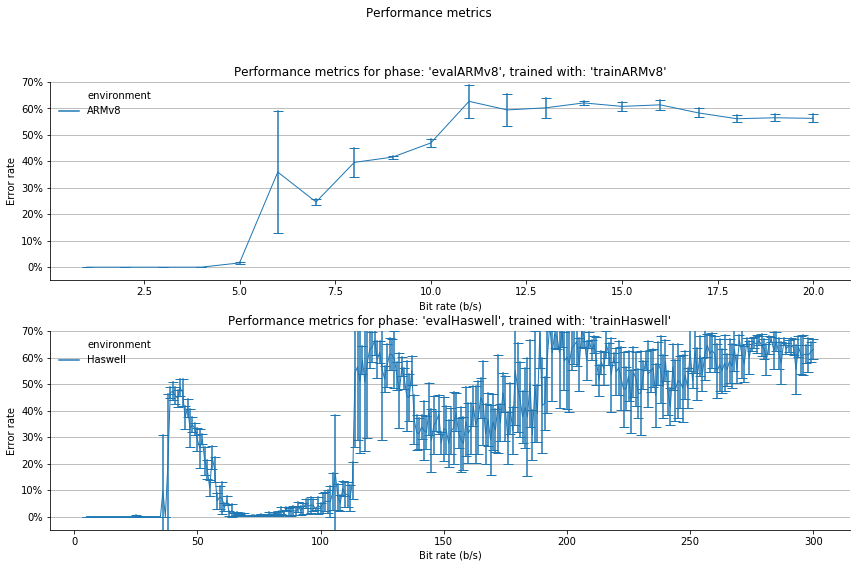

In [14]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics()

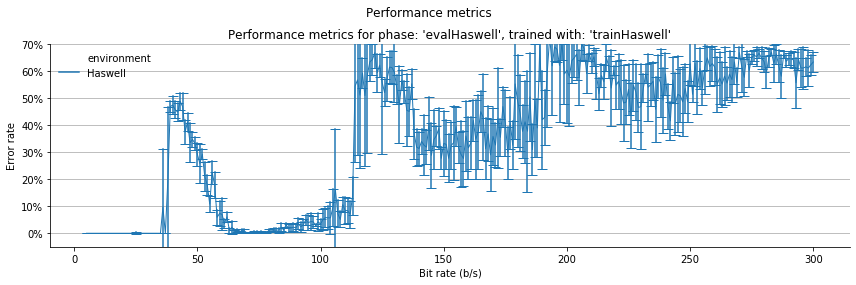

In [21]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics(selector={"phase": "evalHaswell"})

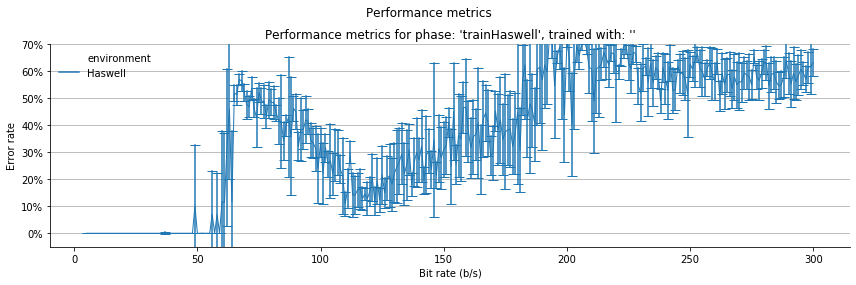

In [22]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics(selector={"phase": "trainHaswell"})